<a href="https://colab.research.google.com/github/ntminh981/ApplyParallelProgramming_Group5/blob/main/Parallel/PoissionMatting_Parallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PARALLEL POISSION MATTING

## Nhóm 5


1.   Nguyễn Tấn Minh - 19127473
  - Bản song song 2
  - Bản song song 3
  - Viết report
2.   Phạm Cao Minh - 19127474
  - Bản tuần tự
  - Bản song song 1
  - Làm slide thuyết trình

Github: https://github.com/ntminh981/ApplyParallelProgramming_Group5

# Giới thiệu
Mục tiêu của nhóm là song song hóa thuật toán Poisson Matting, là một thuật toán xử lí ảnh dùng để loại bỏ background, bằng thư viện Numba của Python. Project này bao gồm implement lại phiên bản tuần tự, sau đó tối ưu hóa với các phiên bản song song.

# 1. Clone git project

In [ ]:
import os
if not os.path.exists('/content/git'):
  !git clone https://github.com/ntminh981/ApplyParallelProgramming_Group5.git git

Cloning into 'git'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 79 (delta 21), reused 37 (delta 7), pack-reused 0
Receiving objects: 100% (79/79), 8.96 MiB | 14.33 MiB/s, done.
Resolving deltas: 100% (21/21), done.


# 2. Khai báo thư viện

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# import plotly.express as px
import os
from  scipy import ndimage
import time
import scipy
from scipy.optimize import fmin

import os
from numba import cuda, jit

# 3. Load & show input

In [ ]:
IMAGES_FOLDER_PATH  = "/content/git/img"
img_name            = 'img3.png'
trimap_name         = 'tri3.png'
new_bg_name         = 'new_bg3.jpg'

In [ ]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    """
    Utility Function to Display Images
    :param img_arr : List of numpy array representing images
    :param r: Number of rows in the subplot
    :param c: Number of coloumns in the subplot
    :param dim: Figure Size of the subplot
    :param titles_arr: Title corresponding to each image in img_arr
    """
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()

def read_img(im_names,path=IMAGES_FOLDER_PATH):
    """
    Utitlity Function to Read Images from file
    :param im_names: Name of the image file in the images folder, directed using the IMAGES_FOLDER_PATH variable
    :return: Two seperate lists containing the colored and grayscale version of images as numpy array
    """
    im = []
    im_gray = []
    for name in im_names:
        img =  cv2.imread(path+'/'+name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if(len(im)>=1):
            img = cv2.resize(img,(im[0].shape[1],im[0].shape[0]))
        im.append(img)
        im_gray.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return im, im_gray

In [ ]:
img = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, img_name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, img_name),0)
tri = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, trimap_name),0)

new_bg = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, new_bg_name))
new_bg = cv2.cvtColor(new_bg, cv2.COLOR_BGR2RGB)
new_bg = cv2.resize(new_bg, (img.shape[1],img.shape[0]))

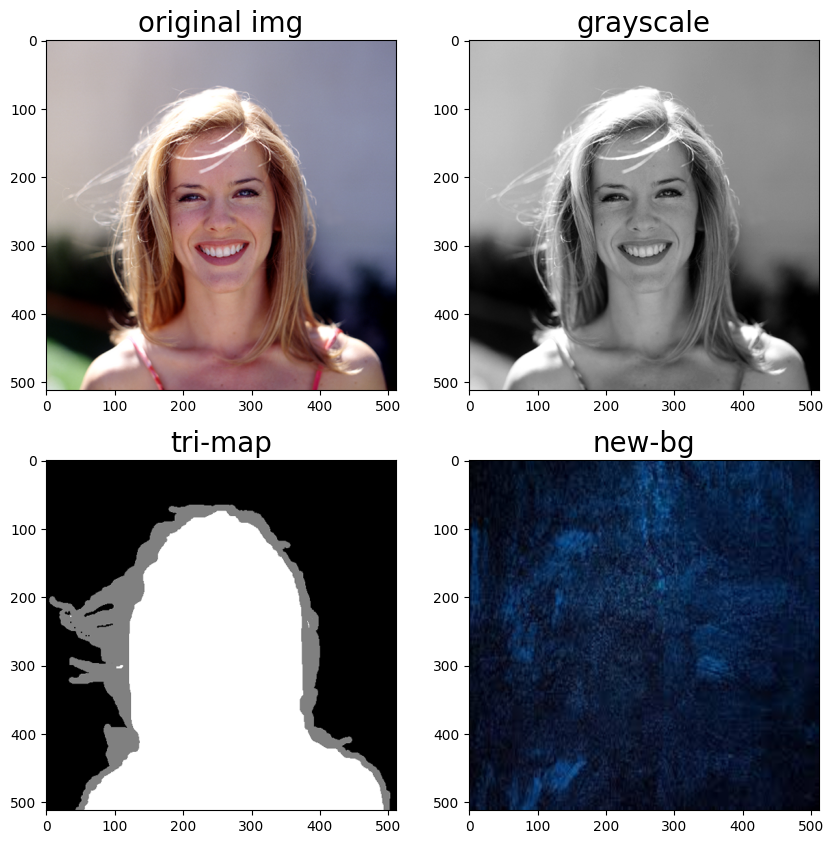

In [ ]:
display_img_arr([img,img_gray,tri,new_bg], 2,2,(10,10), ['original img','grayscale','tri-map','new-bg'])

# 4. Thuật toán Global Matting

+ 1 image có thể được biểu diễn như sau:

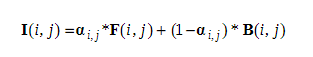

+ Đạo hàm 2 vế:

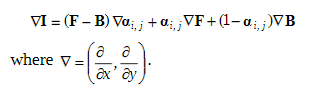

+ Giả sử foreground và background smooth, tức là $\Delta F$ và $\Delta B$ tiệm cận 0:
$$\nabla I=(F-B)\nabla \alpha ⟹ \nabla \alpha =\frac{\nabla I}{F-B}$$

+ Poisson Equation
$$\Delta \alpha = div (\frac{\nabla I}{F-B})$$
where, $\Delta = (\frac{\partial^2}{\partial x^2},\frac{\partial^2}{\partial y^2})$
is Laplacian Operator and div is divergence opertor

+ Giải Poisson Equation bằng Phép lặp Gauss Siedel với phương pháp overrealaxation.

 Với,  $$ \frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2} = S$$
$$ {f_{i,j}}^{(n+1)} = \frac{\beta}{4}({f_{i+1,j}}^{(n)} + {f_{i-1,j}}^{(n+1)} + {f_{i,j+1}}^{(n)} + {f_{i,j-1}}^{(n+1)} - S_{i,j}) + (1-\beta){f_{i,j}}^{(n)}$$

$\beta$ nằm trong khoảng [1,2] (chọn $\beta$=1)



## Thiết kế song song

## Implement

## Utils

Bao gồm các hàm util để thực hiện các bước chung như:
- tính toán mask foreground, background, unknown
- approximate foreground, background
- tính đạo hàm
- estimate alpha cho lần tính alpha đầu tiên

Chi tiết các hàm được chú thích dưới từng hàm

In [ ]:
from posixpath import join
def calc_masks(tri, img_gray):
    """
    Utility Function to Create Masks
    :param tri: A numpy array representing the trimap of the image in Grayscale
    :param img_gray: A numpy array representing the Grayscale version of the image
    :return A list of numpy array representing the foreground mask, foreground image, background mask,
            background image, unknown region mask,unknown region image
    """
    mask_bg = (tri<10)
    mask_fg = (tri>245)
    mask_unknown = (np.bitwise_and(tri>=10,tri<=245))

    fg = img_gray*(mask_fg)
    bg = img_gray*(mask_bg)
    unknown = img_gray*mask_unknown
    return [mask_fg,fg,mask_bg,bg,mask_unknown,unknown], ['fg mask','fg','bg mask','bg','mask unknown','unkown reg img']

def fb(img_gray,mask_fg,mask_bg,mask_unknown):
    """
    Utility Function to find the Approximate Foreground and Approximate Background using the Trimap provided
    :param img_gray: A numpy array representing the Grayscale version of Image
    :param mask_fg: A numpy array representing the pixels in the Foreground Region
    :param mask_bg: A numpy array representing the pixels in the Background Region
    :param mask_unknown: A numpy array representing the pixels in the Unknown Region
    :returns :Two numpy arrays representing Approximate Foreground and Approximate Background respectively
    """
    F = img_gray*(mask_fg+mask_unknown)
    B = img_gray*(mask_bg+mask_unknown)
    return F, B

def grads(F,B,mask_fg,img_gray,mask_unknown):
    """
    Finding the Gradient and Difference required for the Poisson Equation and
    the Estimate Alpha for Global Mating
    :param F: A numpy array representing Approximate Foreground
    :param B: A numpy array representing Approximate Background
    :param mask_fg: A numpy array representing the pixels in the Foreground Region
    :param img_gray: A numpy array representing the Grayscale version of Image
    :param mask_unknown: A numpy array representing the pixels in the Unknown Region

    :returns :A numpy array representing the estimate alpha, A numpy array representing Double Differential
               A numpy array representing the difference of Approximate Foreground and Background
    """
    diff = np.minimum(np.maximum(F-B,0),255)

    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)
    grad_y,grad_x = np.gradient(img_gray)
    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient(grad_y/diff)
    _, d2x_alpha = np.gradient(grad_x/diff)
    d2alpha = d2y_alpha + d2x_alpha
    estimate_alpha = mask_fg + 0.5*mask_unknown
    return estimate_alpha, d2alpha, diff

def func_estimate_alpha(tri, img_gray):
    """
    Main Function to calculate the estimate alpha
    :params tri: trimap
    :params img_gray: gray input image
    :returns estimated alpha
    """
    imgs, titles = calc_masks(tri, img_gray)
    display_img_arr(imgs, 3,2,(10,10),titles)
    mask_fg, fg, mask_bg, bg, mask_unknown, unknown = imgs

    F,B = fb(img_gray,mask_fg,mask_bg,mask_unknown)
    display_img_arr([F,B], 1,2,(10,10),['F','B'])
#     print(mask_fg.shape,fg.shape,mask_bg.shape,bg.shape,mask_unknown.shape,unknown.shape,F.shape,B.shape,img_gray.shape)
    est_alpha, d2alpha, diff =  grads(F,B,mask_fg,img_gray,mask_unknown)
    return est_alpha, F, B, d2alpha, imgs, diff

## Các phiên bản Poisson Matting

### Tuần tự

Dùng 2 vòng for để thực hiện tính theo công thức đã trình bày ở trên, đúng với thứ tự từ trái qua phải, từ trên xuống dưới
$$ {f_{i,j}}^{(n+1)} = \frac{\beta}{4}({f_{i+1,j}}^{(n)} + {f_{i-1,j}}^{(n+1)} + {f_{i,j+1}}^{(n)} + {f_{i,j-1}}^{(n+1)} - S_{i,j}) + (1-\beta){f_{i,j}}^{(n)}$$

Chọn $\beta$ = 1 để biểu thức đơn giản hơn

In [ ]:
def globalAlphaMatting(alpha,d2alpha,unknown_seg,iters = 50, threshold = 0.1, beta = 1):
    """
    Implements Global Matting as discussed in the paper. Using image gradients, Approximate Foreground and Approximate
    Background, it solves the Poisson Equation with the help of Gauss Siedel Approximation
    :param alpha: The Estimated value of Alpha for the Final Matte
    :param d2alpha: Sum of Double Differential in X and Y. Required to solve the Poisson Equation
    :param unknown_seg: A numpy array representing the pixels in the unknown region of the image/trimap
    :param iters: Number of Iterations the Gauss Siedel Approximation wil run
    :param threshold: If the amount of change happening after each iteration is below threshold, the program will end
    :param beta: The Beta Factor involved in Gauss Siedel Approximation

    :returns :A numpy array representing Matte produced and time taken to calculate it
    """
    prev_alpha = np.zeros(alpha.shape)

    tic = time.time()
    for _ in range(iters):
        diff = np.sum(np.abs(prev_alpha-alpha))
        if diff < threshold:
            break
        for i in range(1,alpha.shape[0]-1):
            for j in range(1,alpha.shape[1]-1):
                if unknown_seg[i,j]!=0 :
                    alpha[i,j] = ((beta*(alpha[i,j-1]+alpha[i-1,j]+prev_alpha[i,j+1]+prev_alpha[i+1,j] - d2alpha[i,j])/4) + (1-beta)*prev_alpha[i,j])

        prev_alpha = alpha.copy()
    tac = time.time()
    return alpha, tac-tic

### Song song

Khai báo các mảng trên device, sau đó chỉ dùng `cuda.copy_to_device()` để tránh lỗi `UNKNOWN_CUDA_ERROR` do bộ nhớ trên device không được giải phóng

In [ ]:
SegmentSize = (img_gray.shape[0], img_gray.shape[1])
d_alpha = cuda.device_array(SegmentSize, dtype=float)
d_d2alpha = cuda.device_array(SegmentSize, dtype=float)
d_unknown = cuda.device_array(SegmentSize, dtype=np.uint8)
d_prev_alpha = cuda.device_array(SegmentSize, dtype=float)

Hàm `copyToDevice()` gồm các bước để copy các mảng cần thiết từ host qua device

In [ ]:
def copyToDevice(estimate_alpha, d2alpha, unknown):
  global d_alpha, d_d2alpha, d_tmp_unknown, d_prev_alpha

  alpha = estimate_alpha.copy()
  prev_alpha = np.zeros(alpha.shape)

  d_alpha.copy_to_device(alpha)
  d_d2alpha.copy_to_device(d2alpha)
  d_unknown.copy_to_device(unknown)
  d_prev_alpha.copy_to_device(prev_alpha)

#### Phiên bản song song 1

Phép toán ở mỗi pixel unknown (i, j) sẽ phụ thuộc vào pixel không phải là unknown ở bên trái (i, j-1) và bên trên (i-1, j) của nó , và những pixel unknown sau thực hiện tính xong cũng sẽ được đánh dấu là không phải unknown.

Do đó nhóm sẽ thực hiện song song theo từng hàng. Mỗi block sẽ là mảng 1 chiều với kích thước (1, MAX_THREADS_PER_BLOCK), grid size là (1, ⌈W/MAX_THREADS_PER_BLOCK⌉). Với những pixel có 1 trong 2 pixel bên trái hoặc bên trên của nó là unknown, thread sẽ chờ tới khi cả 2 giá trị đó được tính toán xong bằng cách sử dụng 1 hàm while.

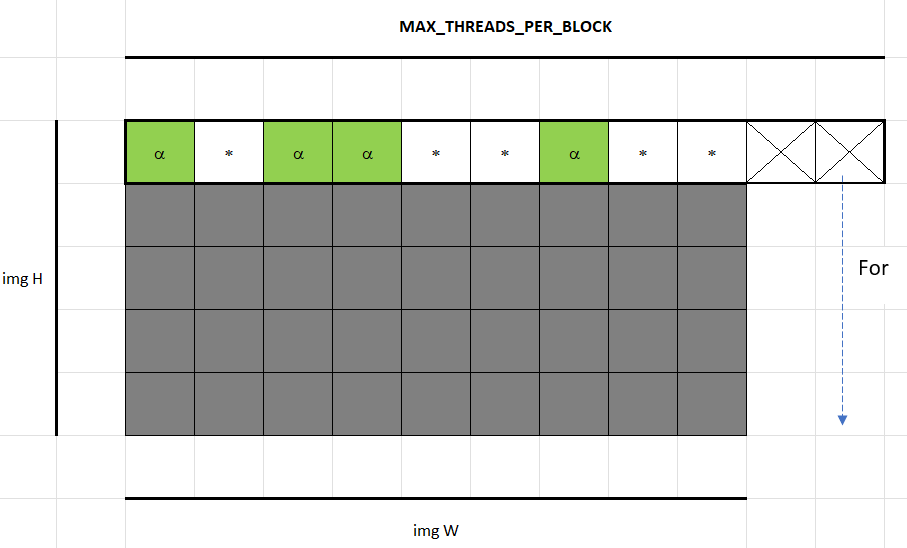

In [ ]:
@cuda.jit
def globalAlphaMatting_parallel_1(row, alpha,prev_alpha,d2alpha,unknown_seg,beta = 1):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    # row = 1
    col = tx + ty * bw + 1

    k=0
    if col < alpha.shape[1]:  # Check array boundaries
      if unknown_seg[row,col]:
        while unknown_seg[row-1,col] or unknown_seg[row,col-1]:
          k+=1
        alpha[row,col] = beta*(alpha[row-1,col]+alpha[row,col-1]+prev_alpha[row,col+1]+prev_alpha[row+1,col] - d2alpha[row,col])/4
        unknown_seg[row,col] = 0

#### Phiên bản song song 2

Khác với phiên bản 1, phiên bản này sẽ song song trên toàn bộ pixel của bức hình, với mỗi block có kích thước (32*32). Do đó 1 pixel unknown (i, j) phải đợi cả pixel bên trái và bên trên của nó nếu 1 trong 2 pixel đó là unknown.

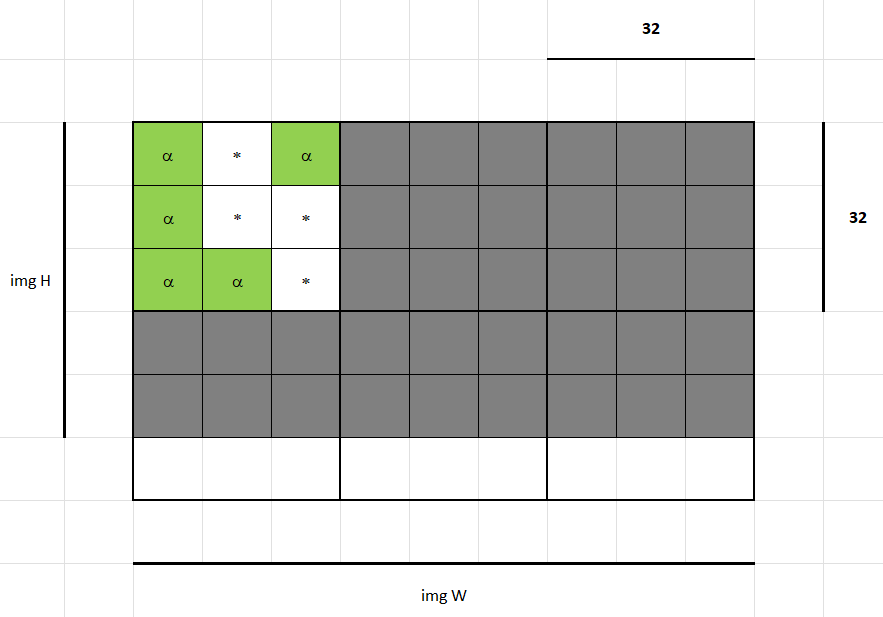

In [ ]:
@cuda.jit
def globalAlphaMatting_parallel_2(alpha,prev_alpha,d2alpha,unknown_seg,beta = 1):
    row, col = cuda.grid(2)

    k=0
    if (col < alpha.shape[1]) and (row < alpha.shape[0]):  # Check array boundaries
      if unknown_seg[row,col]:
        while unknown_seg[row-1,col] or unknown_seg[row,col-1]:
          pass
        alpha[row,col] = beta*(alpha[row-1,col]+alpha[row,col-1]+prev_alpha[row,col+1]+prev_alpha[row+1,col] - d2alpha[row,col])/4
        unknown_seg[row,col] = False

#### Phiên bản song song 3

Phiên bản này được hình thành dựa vào phiên bản 1 và 2. Block size là (1, MAX_THREADS_PER_BLOCK), grid size là (H, ⌈W/MAX_THREADS_PER_BLOCK⌉). Ý tưởng là sẽ ưu tiên các pixel trong cùng 1 dòng sẽ chạy chung trong 1 block, và sẽ chạy song song tất cả các dòng 1 lúc.

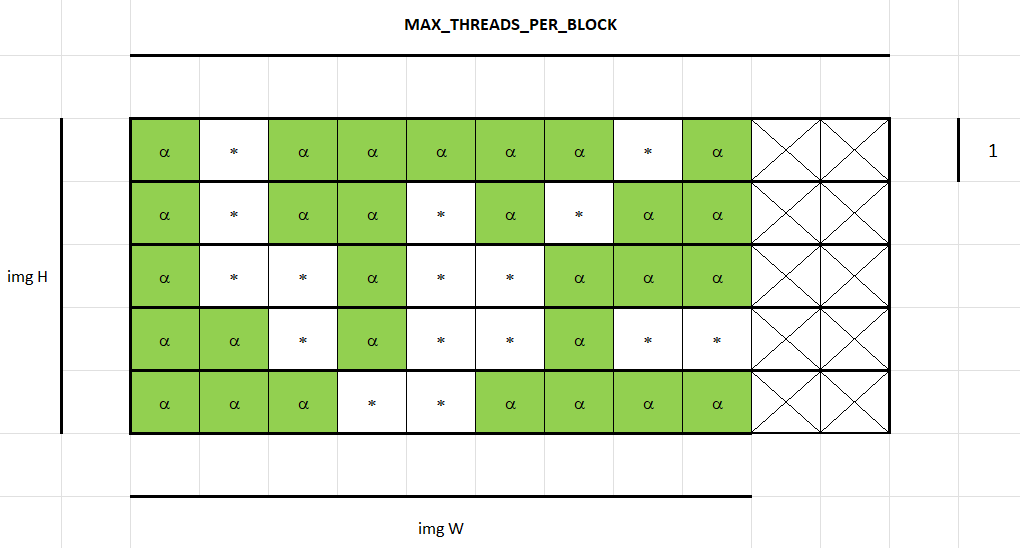

In [ ]:
@cuda.jit
def globalAlphaMatting_parallel_3(alpha,prev_alpha,d2alpha,unknown_seg,beta = 1):
    row, col = cuda.grid(2)

    if (col < alpha.shape[1]) and (row < alpha.shape[0]):  # Check array boundaries
      if unknown_seg[row,col]:
        while unknown_seg[row-1,col] or unknown_seg[row,col-1]:
          pass
        alpha[row,col] = beta*(alpha[row-1,col]+alpha[row,col-1]+prev_alpha[row,col+1]+prev_alpha[row+1,col] - d2alpha[row,col])/4
        unknown_seg[row,col] = 0

## Hàm main

Hàm `matting_combined(tri, img_gray, useCuda)` là hàm chính dùng để gọi tới các phiên bản tuần tự và song song.
- `tri`: trimap
- `img_gray`: gray scale image từ input
- `useCuda`: phiên bản cần gọi, 0 là bản tuần tự, 1-3 là các phiên bản song song
Output là 1 dictionary chứa mảng Alpha Matting cần tìm và các thông tin có được sau khi chạy

Ở mỗi phiên bản song song, hàm này sẽ thực hiện các bước tính block size và grid size như đã trình bày ở các phần trên, copy mảng sang device, compile và gọi kernel.

In [ ]:
def matting_combined(tri, img_gray, useCuda=0):
    """
    Main Function to calculate the Matte
    :params tri: trimap
    :params img_gray: gray input image
    returns all images dict used for matting: {'alpha': alpha, 'F':F, 'B': B, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown}
    """
    global d_alpha, d_d2alpha, d_tmp_unknown, d_prev_alpha

    estimate_alpha, F, B, d2alpha, imgs, diff = func_estimate_alpha(tri, img_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs

    if useCuda:
      alpha = estimate_alpha.copy()
      prev_alpha = np.zeros(alpha.shape)
      copyToDevice(estimate_alpha, d2alpha, unknown)
      threshold = 0.1

      if useCuda ==1 :
        # Get the current CUDA device
        device = cuda.get_current_device()

        # Get the maximum threads per block for the current device
        max_threads_per_block = device.MAX_THREADS_PER_BLOCK

        block_size = max_threads_per_block
        grid_size = int(np.ceil(img_gray.shape[1]/block_size))

        # compile
        globalAlphaMatting_parallel_1[block_size, grid_size](1, d_alpha, d_prev_alpha, d_d2alpha, d_unknown, 1)
        copyToDevice(estimate_alpha, d2alpha, unknown)

        tic = time.time()
        for _ in range(50):
            diff = np.sum(np.abs(prev_alpha-alpha))
            if diff < threshold:
                break

            d_unknown.copy_to_device(unknown)
            d_prev_alpha.copy_to_device(prev_alpha)

            for i in range(1,alpha.shape[0]-1):
                globalAlphaMatting_parallel_1[block_size, grid_size](i, d_alpha, d_prev_alpha, d_d2alpha, d_unknown, 1)

            d_alpha.copy_to_host(alpha)
            alpha = np.minimum(np.maximum(alpha,0),1)
            prev_alpha = alpha.copy()

        tac = time.time()
        deltaTime = tac-tic

      elif useCuda == 2:
        block_size = (32, 32)
        grid_size = (int(np.ceil(img_gray.shape[0]/block_size[0])), int(np.ceil(img_gray.shape[1]/block_size[0])))

        # compile
        globalAlphaMatting_parallel_2[block_size, grid_size](d_alpha, d_prev_alpha, d_d2alpha, d_unknown, 1)
        copyToDevice(estimate_alpha, d2alpha, unknown)

        tic = time.time()
        for _ in range(50):
            diff = np.sum(np.abs(prev_alpha-alpha))
            if diff < threshold:
                break

            d_unknown.copy_to_device(unknown)
            d_prev_alpha.copy_to_device(prev_alpha)

            globalAlphaMatting_parallel_2[block_size, grid_size](d_alpha, d_prev_alpha, d_d2alpha, d_unknown, 1)

            d_alpha.copy_to_host(alpha)
            alpha = np.minimum(np.maximum(alpha,0),1)
            prev_alpha = alpha.copy()
        tac = time.time()
        deltaTime = tac-tic

      elif useCuda == 3 :
        # Get the current CUDA device
        device = cuda.get_current_device()

        # Get the maximum threads per block for the current device
        max_threads_per_block = device.MAX_THREADS_PER_BLOCK

        block_size = (1, max_threads_per_block)
        grid_size = (img_gray.shape[0], int(np.ceil(img_gray.shape[1]/block_size[1])))
        print('blocksize: ', block_size)
        print('gridsize: ', grid_size)

        # compile
        globalAlphaMatting_parallel_3[block_size, grid_size](d_alpha, d_prev_alpha, d2alpha, d_unknown, 1)
        copyToDevice(estimate_alpha, d2alpha, unknown)

        tic = time.time()
        for _ in range(50):
            diff = np.sum(np.abs(prev_alpha-alpha))
            if diff < threshold:
                break

            d_unknown.copy_to_device(unknown)
            d_prev_alpha.copy_to_device(prev_alpha)

            globalAlphaMatting_parallel_3[block_size, grid_size](d_alpha, d_prev_alpha, d_d2alpha, d_unknown, 1)

            d_alpha.copy_to_host(alpha)
            alpha = np.minimum(np.maximum(alpha,0),1)
            prev_alpha = alpha.copy()
        tac = time.time()
        deltaTime = tac-tic

    else:
      alpha, deltaTime = globalAlphaMatting(estimate_alpha,d2alpha,mask_unknown, 50, 0.1, 1)
      alpha = np.minimum(np.maximum(alpha,0),1)

    return {'alpha': alpha, 'F':F, 'B': B, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown, 'time':deltaTime}

## Alpha blending

Áp dụng công thức I = α F + (1 − α )B để tạo ra bức ảnh với background mới

In [ ]:
def alpha_blend(new_bg,alpha,img):
    """
    Utility Function to Calculate the Image on a New Background using the Matte produced by anyone of the methods
    :param new_bg: A numpy array representing the New Background (Coloured)
    :param alpha: A numpy array representing the matte produced
    :param img: Original Image containing the foreground
    """
    new_img = np.zeros(new_bg.shape)
    new_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)*new_bg[:,:,0]
    new_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)*new_bg[:,:,1]
    new_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)*new_bg[:,:,2]
    return np.int64(new_img)

# 5. Chạy thử

In [ ]:
result = {}

## Sequential

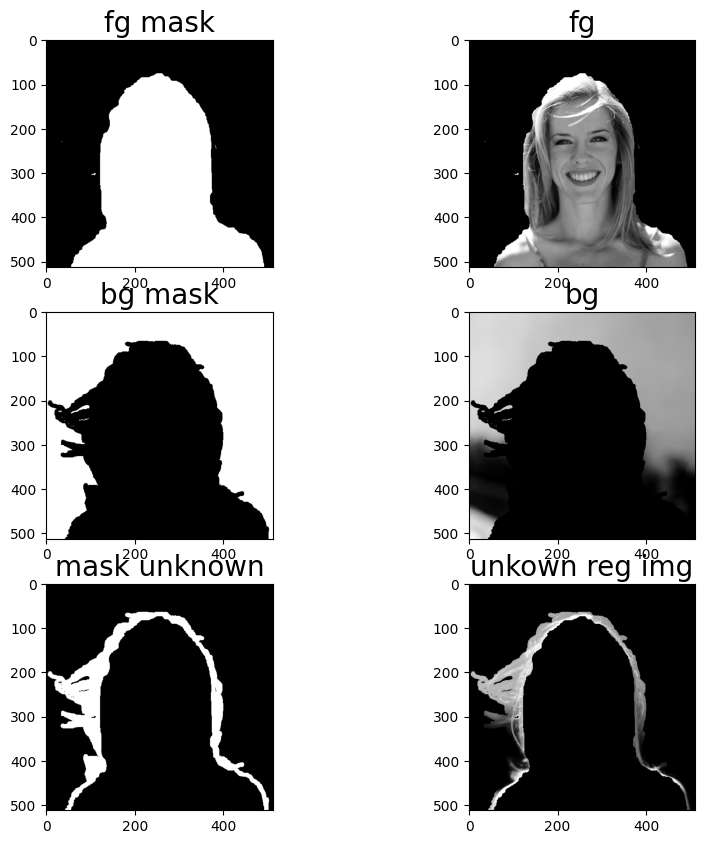

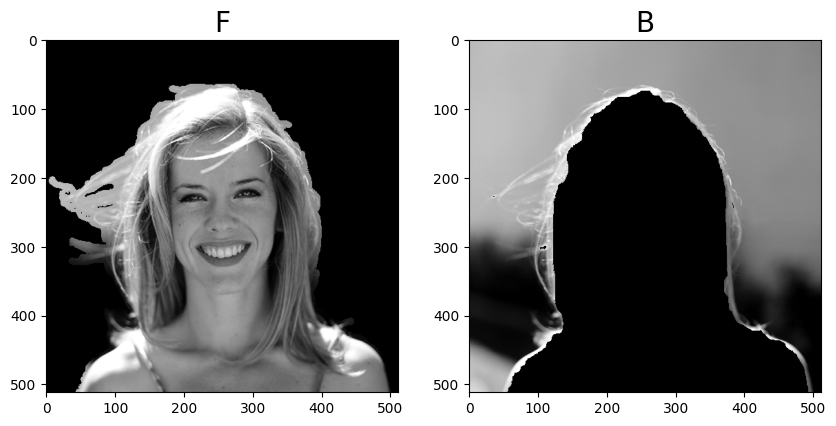

<ipython-input-7-7cc5f2ac129f>:47: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  diff = ndimage.filters.gaussian_filter(diff, 0.9)


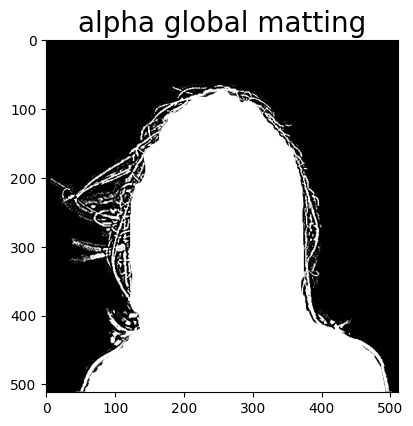

In [ ]:
all_data = matting_combined(tri, img_gray, 0)
## adding images also to this all_data
all_data.update({'img': img, 'img_gray': img_gray})
## NOW all_data VARIABLE CONTAINS img, img_GRAY, ALPHA, DIFF, F, B, UNKNOWN
result['sequential'] = all_data

display_img_arr([all_data['alpha']], 1,2,(10,10),['alpha global matting'])

In [ ]:
print('Sequential version: ', all_data['time'])

Sequential version:  0.47670602798461914


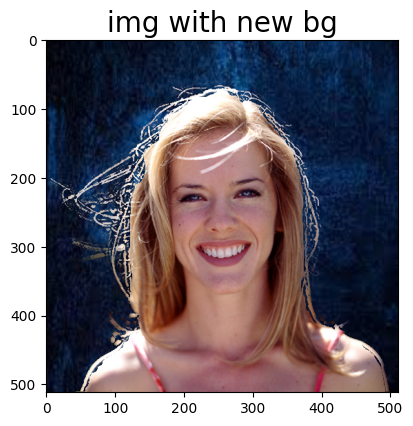

In [ ]:
new_img = alpha_blend(new_bg,all_data['alpha'],img)
display_img_arr([new_img ], 1,2,(10,10),['img with new bg'])

## Parallel

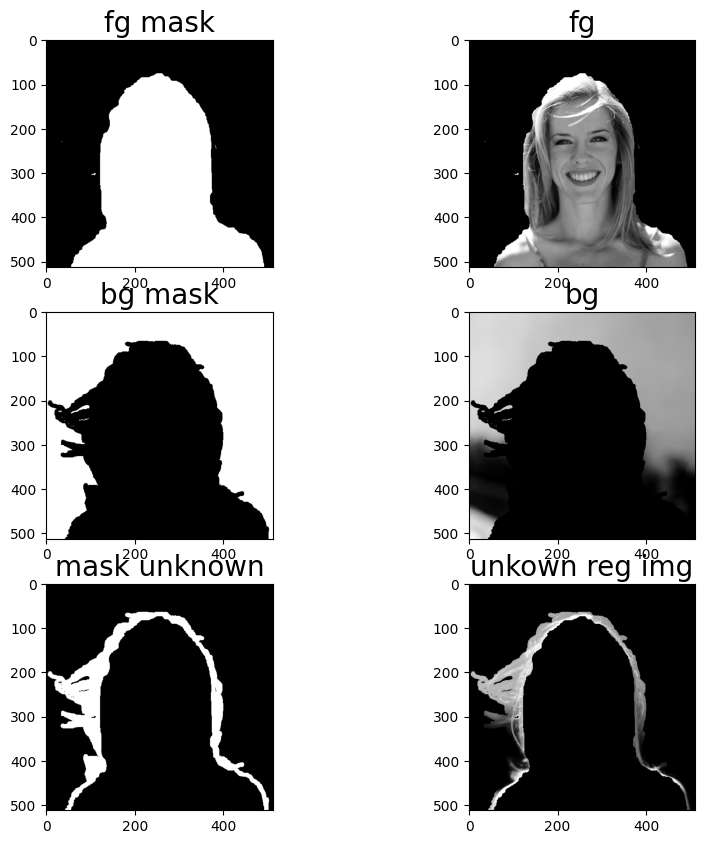

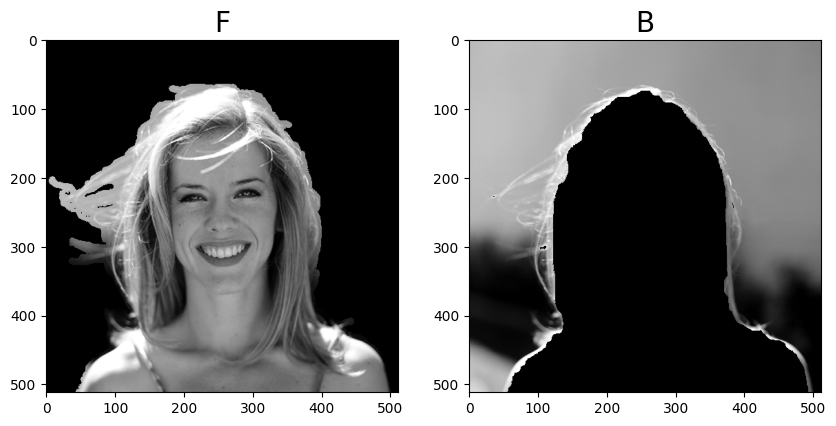

<ipython-input-7-7cc5f2ac129f>:47: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  diff = ndimage.filters.gaussian_filter(diff, 0.9)


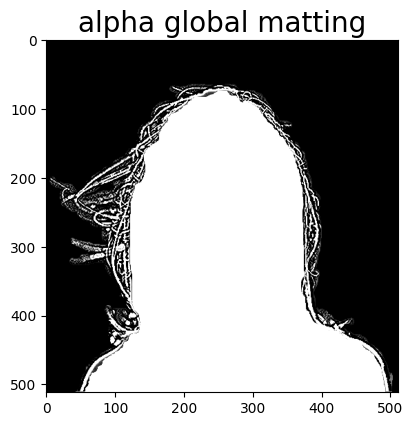

In [ ]:
all_data = matting_combined(tri, img_gray, 1)
## adding images also to this all_data
all_data.update({'img': img, 'img_gray': img_gray})
all_data_3 = all_data.copy()

result['version_1'] = all_data

display_img_arr([all_data['alpha']], 1,2,(10,10),['alpha global matting'])

In [ ]:
print('Parallel version: ', all_data['time'])

Parallel version:  0.04440045356750488


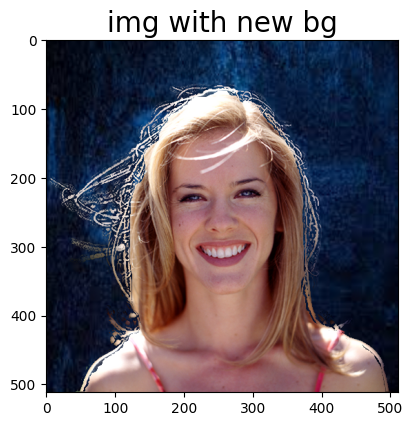

In [ ]:
new_img = alpha_blend(new_bg,all_data['alpha'],img)
display_img_arr([new_img ], 1,2,(10,10),['img with new bg'])

## Parallel 2

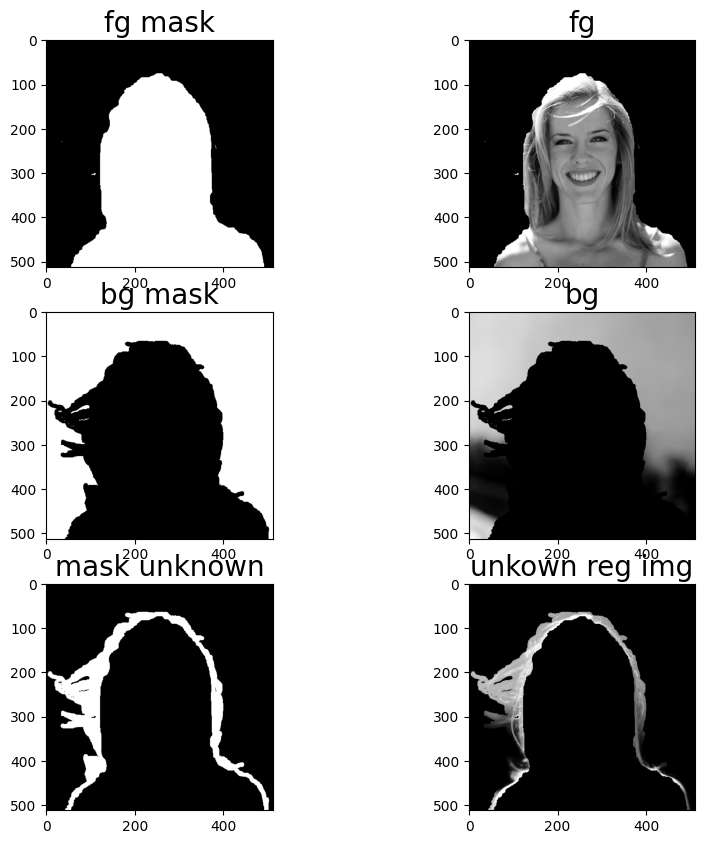

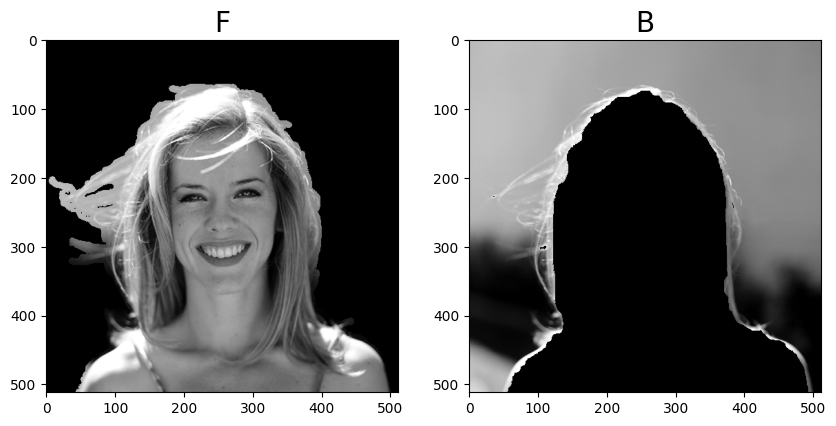

<ipython-input-7-7cc5f2ac129f>:47: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  diff = ndimage.filters.gaussian_filter(diff, 0.9)


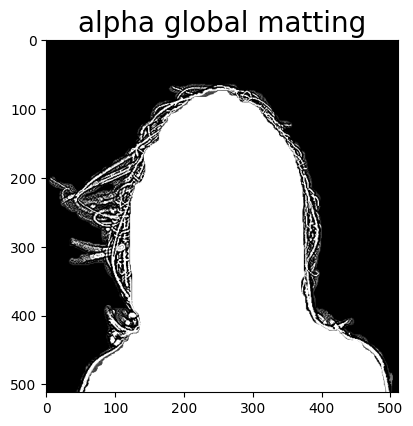

In [ ]:
all_data = matting_combined(tri, img_gray, 2)
## adding images also to this all_data
all_data.update({'img': img, 'img_gray': img_gray})
all_data_3 = all_data.copy()

result['version_2'] = all_data

display_img_arr([all_data['alpha']], 1,2,(10,10),['alpha global matting'])

In [ ]:
print('Parallel version: ', all_data['time'])

Parallel version:  0.004998683929443359


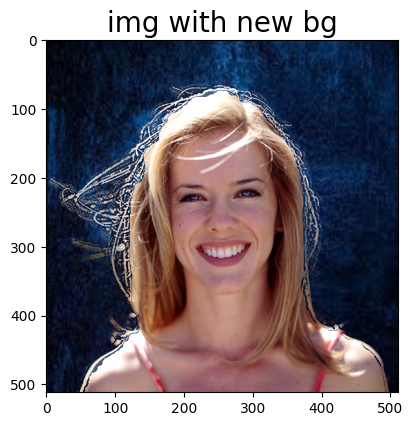

In [ ]:
new_img = alpha_blend(new_bg,all_data['alpha'],img)
display_img_arr([new_img ], 1,2,(10,10),['img with new bg'])

## Parallel 3

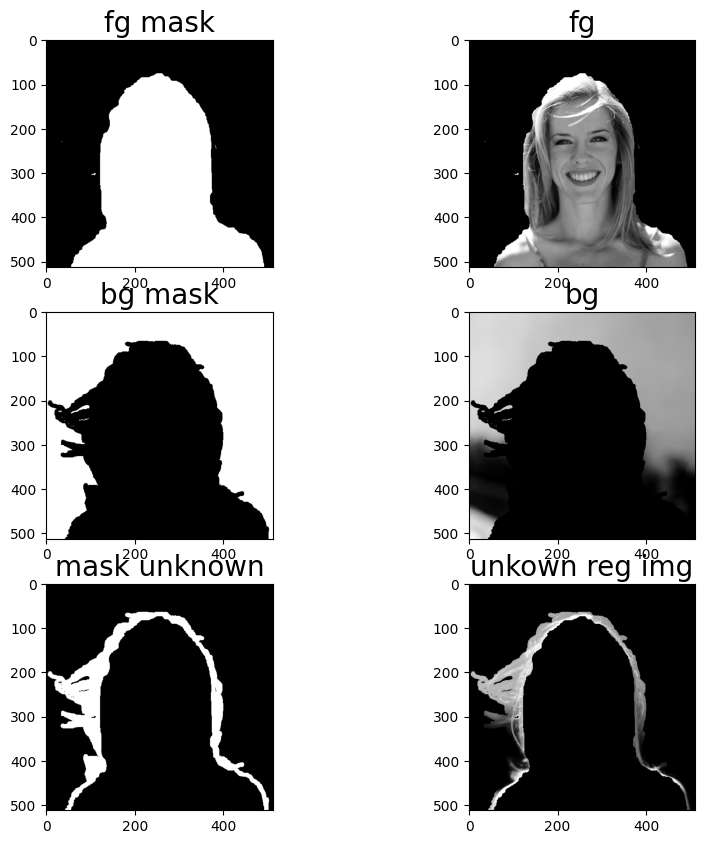

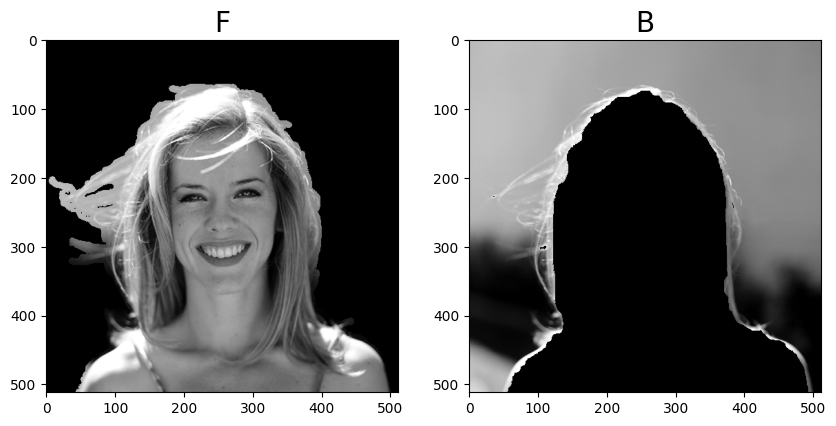

<ipython-input-7-7cc5f2ac129f>:47: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  diff = ndimage.filters.gaussian_filter(diff, 0.9)


blocksize:  (1, 1024)
gridsize:  (512, 1)


/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


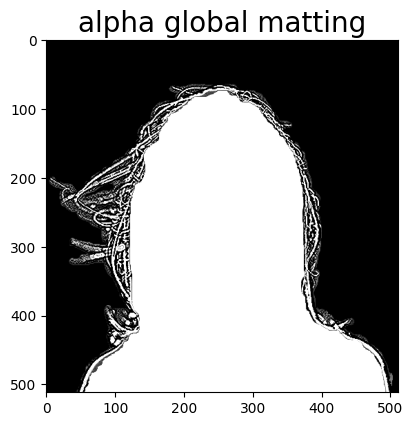

In [ ]:
all_data = matting_combined(tri, img_gray, 3)
## adding images also to this all_data
all_data.update({'img': img, 'img_gray': img_gray})
all_data_3 = all_data.copy()

result['version_3'] = all_data

display_img_arr([all_data['alpha']], 1,2,(10,10),['alpha global matting'])

In [ ]:
print('Parallel version: ', all_data['time'])

Parallel version:  0.0049741268157958984


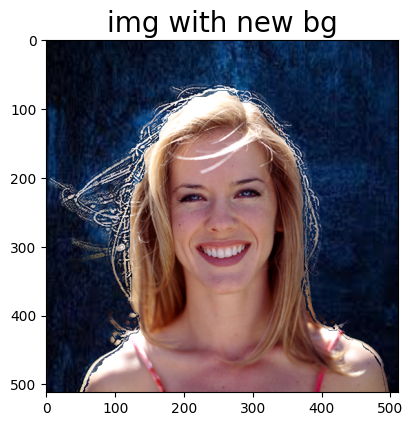

In [ ]:
new_img = alpha_blend(new_bg,all_data['alpha'],img)
display_img_arr([new_img ], 1,2,(10,10),['img with new bg'])

# 6. So sánh kết quả

Lấy phiên bản tuần tự làm mốc, tính độ lỗi trung bình trên các điểm unknown so với các phiên bản song song để kiểm tra tính chính xác.

Ở đây nhóm sử dụng mảng alpha matting (giá trị từ 0-1) có được từ các lần chạy để so sánh.

In [ ]:
np.count_nonzero(result['sequential']['mask_unknown']==False)

232364

In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd

sequential_ver = result['sequential']
n_unknown = np.count_nonzero(result['sequential']['mask_unknown']==True)
table = [('sequential', 0, sequential_ver['time'])]

for version in result:
  if version != 'sequential':
    diff = np.sum(np.abs(sequential_ver['alpha'] - result[version]['alpha']))#.sum()#.mean()
    diff /= n_unknown
    table.append((version, diff, result[version]['time']))

data = pd.DataFrame(table, columns=['Version', 'Error', 'Time'])
data

,Version,Error,Time
0,sequential,0.000000,0.476706
1,version_1,0.078780,0.044400
2,version_2,0.119256,0.004999
3,version_3,0.117078,0.004974


**Nhận xét:**
- Cả 3 phiên bản song song đều có độ lỗi không quá cao so với bản tuần tự
- Phiên bản 1 (song song theo từng dòng) nhanh khoảng gấp **10 lần** so với bản tuần tự.
- Phiên bản 2 (song song cả bức hình với các block 32\*32) và phiên bản 3 (song song cả bức hình với mỗi block tương đương 1 dòng) có thời gian thực thi gần như ngang nhau và gấp khoảng **100 lần** bản tuần tự

# Reference

https://github.com/avani17101/Poisson-Matting